In [1]:
import pandas as pd
import numpy as np
import random
import math
import scipy
from scipy import stats

from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn.model_selection import train_test_split  # for train/test split
import matplotlib.pyplot as plt  #For representation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c  # for L1 regluarization path

# Netork modules
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim

import copy

# Example code for calculating accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from statkit.decision import net_benefit

from scipy import integrate


from sklearn.datasets import make_classification


from sklearn.preprocessing import StandardScaler


# Initialize

Define funtions

### Synthetic data

In [2]:
# Initialise sklearn LR (used for comparison)

logreg = LogisticRegression()

In [3]:
def make_class_dataset(n_sample = 100,
                       n_features = 3,
                       n_redundant = 0,
                       random_state = 2001,
                       n_informative = 3,
                       n_clusters_per_class = 1,
                       n_classes = 2):

    # generate data set
    X, Y = make_classification(n_samples=n_sample, 
                               n_features=n_features, 
                               n_redundant=n_redundant, 
                               random_state=random_state, 
                               n_informative=n_informative, 
                               n_clusters_per_class=n_clusters_per_class,
                                n_classes=n_classes)

    # Standardize


    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    ind_var_names = ["x"+str(i) for i in range(n_features)]

    X = pd.DataFrame(X, columns = ind_var_names)
    Y = pd.DataFrame(Y, columns = ["y"])

    df = pd.concat([Y.reset_index(drop=True), X], axis=1)

    # Train test split

    df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234)

    return df_train,df_test, ind_var_names



#dft, dfr = make_class_dataset()

In [4]:
# Make synthetic data #
#=====================#


def make_synth_data(n_features = 3, 
                    n_sample = 1000, 
                    true_coefs = [1.,2.,3.], 
                    noise = 'none', 
                    true_bias = 0.,
                    heteros = 0.):
    # initialise
    df = pd.DataFrame()

    # Standardization of variables
    mean_vars = [0 for i in range(n_features)]
    var_vars = [1 for i in range(n_features)]

    # Amount of noise to add to  each variable
    #noise_scale = [i**2 for i in range(n_features)]
    #noise_scale = [0.05*i/(n_features-1)**2 for i in noise_scale]
    if noise == 'none':
        noise_scale = [0 for i in range(n_features)]
    else:
        noise_scale = noise

    # create normal variables
    for n in range(n_features):
        df[n] =  np.random.normal(loc=mean_vars[n], scale=var_vars[n], size=n_sample)

    # create linear combination
    df["x"] = 0
    for n in range(n_features):
        df["x"] +=  true_coefs[n]*df[n]

    # add heteroscedacity
    df["x"] = df.apply(lambda row: row["x"] + heteros * np.random.normal(loc=0, scale = 1./(1.+np.exp(-row["x"])) ), axis=1)

    

    # include the bias
    df["x"] += true_bias

    
    # Generate outcome

    df["p"] = df.apply(lambda row: 1./(1. + math.exp(-row["x"])), axis=1)
    df["y"] = df.apply(lambda row: np.random.binomial(1, row["p"] ), axis=1)

    # Add noise to each variable
    df_noisy = df.copy()

    for n in range(n_features):
        df_noisy[n] += np.random.normal(loc=0.0, scale=noise_scale[n], size=n_sample)

    #df = df.drop(["x", "p"], axis=1)
    df_noisy = df_noisy.drop(["x", "p"], axis=1)

    # rename the indpendent variables
    ind_var_rename = dict()
    for ind_var_in in range(n_features) :
        ind_var_rename[ind_var_in] = "x"+f"{ind_var_in}"
    df = df.rename(columns=ind_var_rename)
    df_noisy = df_noisy.rename(columns=ind_var_rename)

    ind_var_names = list(ind_var_rename.values())


    # Split the data
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
    df_train, df_test, df_noisy_train, df_noisy_test = train_test_split(df, df_noisy, test_size=0.2, random_state=1234)

    # Standardize each split

    for indep_var in ind_var_names:
        df_train[indep_var] = stats.zscore(df_train[indep_var]) 
        df_test[indep_var] = stats.zscore(df_test[indep_var]) 

        df_noisy_train[indep_var] = stats.zscore(df_noisy_train[indep_var]) 
        df_noisy_test[indep_var] = stats.zscore(df_noisy_test[indep_var]) 

    # scale data
    #sc = StandardScaler()
    #df_train = sc.fit_transform(df_train)
    #X_test = sc.transform(X_test)

    return df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs

In [7]:
def mean_net_benefit(y_true, y_pred, n_thresh):
    thresh = np.linspace(0.0, 1.0, num=n_thresh)

    nb = net_benefit(y_true, y_pred , thresholds=thresh)

    mnb = integrate.simpson(nb[1], x=nb[0])

    return({
        'mnb': mnb,
        'benefit': nb[1],
        'thresholds': nb[0] 
    })

### Torch LR functions

In [8]:

#==================#
#    Load Data     #
#==================#


class SynthDataset(Dataset):


    def __init__(self, df):

        # The target is binary
        self.target = ["y"]   #["flow", "handling", "respect"]
        self.features = ind_var_names
        self.data_frame = df.loc[:, self.target+self.features]
        self.n_features = len(self.features)

        # Save target and predictors
        self.x = self.data_frame[self.features]
        self.y = self.data_frame.loc[:,"y"]


    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        return  [self.x.iloc[idx].values.astype(float),  self.y.iloc[idx].astype(float)] #,  self.handling.iloc[idx].astype(float),  self.respect.iloc[idx].astype(float)]




In [9]:

# Create model
# f = wx + b, sigmoid at the end

class TorchLogisticRegression(nn.Module):

    def __init__(self, n_input_features):
        super(TorchLogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        #y_predicted = torch.sigmoid(self.linear(x))
        y_predicted = self.linear(x)
        return y_predicted


In [10]:
#
# Maximum net benefit loss
#

#class mnbLoss(nn.Module):
#    def __init__(self):
#        super(mnbLoss, self).__init__()
#        #self.weight = weight
#
#    def forward(self, input, target):
#        # Compute the loss
#        loss = -torch.sum(target*input+(1-target)*(input*torch.log(1-input)))
#        return loss
    
class CrossEntropyWithLogit(nn.Module):
    def __init__(self):
        super(mnbLoss, self).__init__()
        #self.weight = weight

    def forward(self, input, target):
        # Compute the loss
        
        # Binary cross entropy with logits
        # this replicates BCEWithLogitsLoss
        #-----------------------------------
        A = torch.log(1.0 + torch.exp(-input))
        loss = target*A+(1.-target)*(input+A)
        loss = torch.mean(loss)



        return loss
    

class mnbLoss(nn.Module):
    def __init__(self):
        super(mnbLoss, self).__init__()
        #self.weight = weight

    def forward(self, input, target):
        # Compute the loss
        
        # Binary cross entropy with logits
        # this replicates BCEWithLogitsLoss
        #-----------------------------------
        A = torch.log(1.0 + torch.exp(-input))
        loss = (1.-target)*(input+A)-torch.sigmoid(input)
        loss = torch.mean(loss)

        return loss
    

In [11]:
#t = mnbLoss()
#t2 = nn.BCELoss()

#tg = torch.tensor([1.0, 0.0])
#pr = torch.tensor([0.2 , 0.4])

#print(t(pr, tg), t2(pr, tg))

#print(tg*torch.log(pr),  (1-tg)*(torch.log(1. - pr)))
#1.-tg
#torch.log(1. - pr)

#torch.cat((tg, pr))

#test_run['loss'][696]

#train_dataset_orig = SynthDataset(df_train)
#    train_x = torch.from_numpy(train_dataset_orig.x.to_numpy().astype(np.float32) )
#train_y = torch.from_numpy(train_dataset_orig.y.to_numpy().astype(np.float32))


#pr = test_run['out'][631].squeeze()

#(train_y.shape, pr.squeeze().shape)

#print(t(pr, train_y) ,t2(pr, train_y))
##df_train['y']


In [12]:
#=======================#
#     LR Training       #
#=======================#


def lr_train(train_in, n_epochs=100, learn_rate = 0.01, save_name_mod = "", loss_fun = 'log'):

    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_x = torch.from_numpy(train_dataset_orig.x.to_numpy().astype(np.float32) )
    train_y = torch.from_numpy(train_dataset_orig.y.to_numpy().astype(np.float32))

    train_y = train_y.view(train_y.shape[0], 1)

    # Define the model
    net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function

    if loss_fun == 'log':
        #criterion = nn.BCELoss()
        criterion = nn.BCEWithLogitsLoss()
        #criterion = mnbLoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)
    #optimizer = optim.Adam(net.parameters(),  lr = 0.001, weight_decay = 0.0001 )

    loss_per_epoch = []

    for epoch in range(n_epochs):

        y_pred = net(train_x)
        loss=criterion(y_pred, train_y)
        loss.backward()
        optimizer.step()

        # Zero the parameter gradients
        optimizer.zero_grad()
         
        loss_per_epoch.append(loss.item())

    #return net
    return {"net": net, "loss": loss_per_epoch}


In [13]:
# Fit with torch implementation
#================================#

#test_run = lr_train(df_train, n_epochs=1000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'mnb')
##test_run = reg_lr_train_legacy(df_train, n_epochs=100, learn_rate=  0.1, save_name_mod = "", loss_fun = 'mnb')
#
#print(test_run['net'].linear.weight, test_run['net'].linear.bias, true_coefs)


## plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
#plt.plot(np.arange(len(test_run['loss'] )), test_run['loss'], "-", alpha=0.5, label="Loss per epoch")
##plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
##    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
#plt.xlabel("Number of epochs")
#plt.ylabel("Loss")
#plt.legend()
#plt.show()

##2.9861,  2.4866, -2.0142

In [14]:
#===================================#
#     Regularized LR Training       #
#===================================#

#tps://www.geeksforgeeks.org/l1l2-regularization-in-pytorch/

def reg_lr_train_legacy(train_in, net = 'none', n_epochs=100, learn_rate = 0.01, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [], lambda_reg = 0.01):

    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_x = torch.from_numpy(train_dataset_orig.x.to_numpy().astype(np.float32))
    train_y = torch.from_numpy(train_dataset_orig.y.to_numpy().astype(np.float32))
    train_y = train_y.view(train_y.shape[0], 1)

    # Define the model
    if net == 'none':
        net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function

    if loss_fun == 'log':
        criterion = nn.BCEWithLogitsLoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
    optimizer = optim.Adam(net.parameters(),  lr = 1.0)
 
    # A tensor of weights for the weighted L1
    if regularization_type == 'weighted_L1':
        weights = [
            torch.from_numpy(np.array([weights])),
            torch.from_numpy(np.array([1.0])),
        ]

    
    loss_per_epoch = []

    for epoch in range(n_epochs):

        y_pred = net(train_x )

        loss=criterion(y_pred, train_y )

        # add regularization term #
        #-------------------------#

        # Apply L1 regularization
        if regularization_type == 'L1':
            #l1_norm = sum(p.abs().sum() for p in net.parameters() )
            l1_norm = [p.abs().sum() for p in net.parameters()][0] 
            #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
            #l1_norm = torch.mean(p.abs().sum() for p in net.parameters() )

            loss += lambda_reg * l1_norm
            
        # Apply weighted L1 regularization
        elif regularization_type == 'weighted_L1':
            #wl1_norm = sum(torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(net.parameters()))
            wl1_norm = [torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(net.parameters())][0]
            loss += lambda_reg * wl1_norm



        loss.backward()
        
        # Gradient cliping
        clipping_value = 1 # arbitrary value of your choosing
        torch.nn.utils.clip_grad_norm(net.parameters(), clipping_value)

        optimizer.step()
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        loss_per_epoch.append(loss.item())

    #return net
    return {"net": net, "loss": loss_per_epoch}

In [15]:
#===================================#
#     Regularized LR Training       #
#===================================#

#tps://www.geeksforgeeks.org/l1l2-regularization-in-pytorch/

def reg_lr_train(train_in, net = 'none',  
                 n_epochs=100, 
                 learn_rate = 1.0, 
                 history_size = 100, 
                 max_iter = 20, 
                 tolerance_grad=1e-07, 
                 tolerance_change=1e-09,
                 loss_fun = 'log', 
                 regularization_type = 'L1',    #'weighted_L1'
                 weights = [], 
                 lambda_reg = 0.01):

    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_x = torch.from_numpy(train_dataset_orig.x.to_numpy().astype(np.float32))
    train_y = torch.from_numpy(train_dataset_orig.y.to_numpy().astype(np.float32))
    train_y = train_y.view(train_y.shape[0], 1)

    # Define the model

    if net == 'none':
        net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function
    if loss_fun == 'log':
        criterion = nn.BCEWithLogitsLoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
    def closure():
        
        lbfgs.zero_grad()
        y_pred = net(train_x)
        loss=criterion(y_pred, train_y)

        # add regularization term #
        #-------------------------#

        # Apply L1 regularization
        if regularization_type == 'L1':
            #l1_norm = sum(p.abs().sum() for p in net.parameters() )
            l1_norm = [p.abs().sum() for p in net.parameters()][0] 
            #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
            #l1_norm = torch.mean(p.abs().sum() for p in net.parameters() )

            loss += lambda_reg * l1_norm
            
        # Apply weighted L1 regularization
        elif regularization_type == 'weighted_L1':
            #wl1_norm = sum(torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(net.parameters()))
            wl1_norm = [torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(net.parameters())][0]
            loss += lambda_reg * wl1_norm

        loss.backward()

        # Gradient clipping:
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
        
        loss_per_epoch.append(loss.item())
        return loss
    
        #optimizer.step()
        
        # Zero the parameter gradients
        #optimizer.zero_grad()
    

    #tol=1e-6,
    #max_iter=int(1e6),
    #warm_start=True,
    #intercept_scaling=10000.0,


    lbfgs = optim.LBFGS(net.parameters(), 
                        lr = learn_rate, 
                        history_size=history_size, 
                        max_iter = max_iter, 
                        tolerance_grad = tolerance_grad,  
                        tolerance_change = tolerance_change, 
                        line_search_fn="strong_wolfe")

    # A tensor of weights for the weighted L1
    if regularization_type == 'weighted_L1':
        weights = [
            torch.from_numpy(np.array([weights])),
            torch.from_numpy(np.array([1.0])),
        ]

    loss_per_epoch = []

    for epoch in range(n_epochs):

        lbfgs.step(closure)

    #print("loss : ")     
    #print(loss)
    #return net
    return {"net": net, "loss": loss_per_epoch}

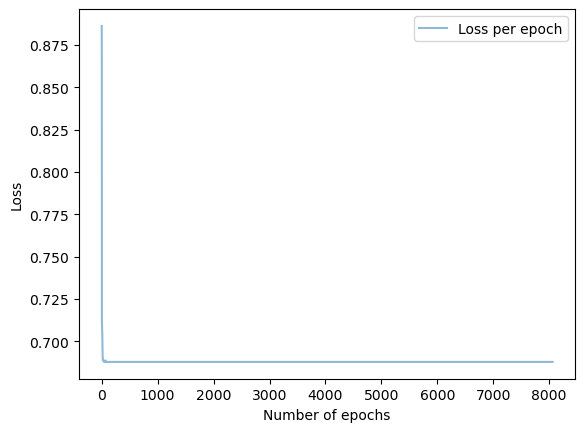

In [16]:
# Create a dataset
#===================#
n_sample = 100000

df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [3, 2.5, -2.0], heteros=0.0) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#-------------------------
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(5, 0, 32)

lda = cs[-1]
lda = 1./(lda)
lda = lda/n_sample
#lda = 0.9*lda

#test_reg = reg_lr_train(df_noisy_train, n_epochs=4000, learn_rate = .001, loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0], lambda_reg=lda )

#test_reg = reg_lr_train(df_noisy_train, 
#                        n_epochs=1000, 
#                        learn_rate = 0.01,
#                        history_size= 100,
#                        max_iter= 100,
#                        tolerance_grad=1e-8,
#                        tolerance_change=1e-10,
#                        loss_fun = 'log', 
#                        regularization_type = 'L1', 
#                        weights = [1.0, 1.0, 1.0], 
#                        lambda_reg=lda )

test_reg = reg_lr_train(df_noisy_train, 
                        n_epochs=1000, 
                        learn_rate = 0.001,
                        #history_size= 1000,
                        #max_iter= 1000,
                        tolerance_grad=1e-8,
                        tolerance_change=1e-10,
                        loss_fun = 'log', 
                        regularization_type = 'L1', 
                        weights = [1.0, 1.0, 1.0], 
                        lambda_reg=lda )

plt.plot(np.arange(len(test_reg['loss'][1:])), test_reg['loss'][1:], "-", alpha=0.5, label="Loss per epoch")
#plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Minibatch version

In [ ]:
def validate(loader, model, criterion, device):                       
    #correct = 0                                               
    #total = 0                                                 
    running_loss = 0.0                                        
    model.eval()
      
    with torch.no_grad():                                     
        for i, data in enumerate(loader):                     
            inputs, labels = data                             
            inputs = inputs.to(device)                        
            labels = labels.to(device)                        
            
            outputs = model(inputs.float()).squeeze()    

            labels_hat=outputs.float()

            #loss = criterion(labels_hat, labels1.squeeze().type(torch.LongTensor)-1)
            loss = criterion(labels_hat.double(), labels.double())

            running_loss = running_loss + loss.item()
         
    return running_loss/(i+1)

In [ ]:
def lr_train_minibatch(train_in, n_epochs=100, batch_size = 30, learn_rate = 0.01, save_name_mod = "", loss_fun = 'log'):
    """Trains the model.
    Args:
        csv_file (str): Absolute path of the dataset used for training.
        n_epochs (int): Number of epochs to train.
    """
    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_size = int(0.8 * len(train_dataset_orig))
    valid_size = len(train_dataset_orig) - train_size
    train_dataset, valid_dataset = random_split(train_dataset_orig, [train_size, valid_size])

    # Dataloaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the model
    net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function

    if loss_fun == 'log':
        criterion = nn.BCEWithLogitsLoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
  
    optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)

    # Train the net
    loss_per_iter = []
    loss_per_batch = []

    #valid_loss_per_iter = []
    valid_loss_per_batch = []

    best_loss = np.inf

    for epoch in range(n_epochs):

        running_loss = 0.0
        for i, (inputs, label) in enumerate(trainloader):
            inputs = inputs.to(device)
            label = label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs.float() ).squeeze()

            label_hat=outputs.float()

            #print("main: inputs = "+str(inputs.shape) + " outputs = "+ str(outputs.shape))
            #print("main: label_hat = "+str(label_hat.shape) + " label = "+ str(label.shape))

            # calculate loss
            #loss=criterion(label_hat, label.squeeze().type(torch.LongTensor)-1)
            loss=criterion(label_hat.double(), label.double() )

            

            #loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Save loss to plot
            running_loss += loss.item()
            loss_per_iter.append(loss.item())

        loss_per_batch.append(running_loss / (i + 1))
        running_loss = 0.0

        # Evaluate validation loss
        vloss = validate(validloader, net, criterion, device)
        valid_loss_per_batch.append(vloss)

        # If validation loss is lower than lowest then save the model
        #if vloss < best_loss:
        #    save_network(net, "best_model"+save_name_mod)
        #    best_loss = vloss

  
    #print("Root mean squared error")
    #print("Training:", np.sqrt(loss_per_batch[-1]))

    return{"model":net,
           "loss_per_batch": loss_per_batch,
           "valid_loss_per_batch": valid_loss_per_batch}



In [ ]:
def reg_validate(loader, model, criterion, device, regularization_type = 'L1', weights = [], lambda_reg = 0.01):                       
    #correct = 0                                               
    #total = 0                                                 
    running_loss = 0.0                                        
    model.eval()
      
    with torch.no_grad():                                     
        for i, data in enumerate(loader):                     
            inputs, labels = data                             
            inputs = inputs.to(device)                        
            labels = labels.to(device)                        
            
            outputs = model(inputs.float()).squeeze()    

            labels_hat=outputs.float()

            #loss = criterion(labels_hat, labels1.squeeze().type(torch.LongTensor)-1)
            loss = criterion(labels_hat.double(), labels.double())


            # add regularization term #
            #-------------------------#

            # Apply L1 regularization
            if regularization_type == 'L1':
                #l1_norm = sum(p.abs().sum() for p in net.parameters() )
                #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
                l1_norm = [p.abs().sum() for p in model.parameters()][0] 
                #l1_norm = torch.mean(p.abs().sum() for p in net.parameters() )

                loss += lambda_reg * l1_norm
            
            #  Apply weighted L1 regularization
            elif regularization_type == 'weighted_L1':
                #wl1_norm = sum(torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(model.parameters()))
                wl1_norm = [torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(model.parameters())][0]
                loss += lambda_reg * wl1_norm
                

            running_loss = running_loss + loss.item()
         
    return running_loss/(i+1)

In [ ]:
def reg_lr_train_minibatch(train_in, n_epochs=100, batch_size = 30, learn_rate = 0.01, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [], lambda_reg = 0.01):
    """Trains the model.
    Args:
        csv_file (str): Absolute path of the dataset used for training.
        n_epochs (int): Number of epochs to train.
    """
    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_size = int(0.8 * len(train_dataset_orig))
    valid_size = len(train_dataset_orig) - train_size
    train_dataset, valid_dataset = random_split(train_dataset_orig, [train_size, valid_size])

    # Dataloaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the model
    net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function

    if loss_fun == 'log':
        criterion = nn.BCEWithLogitsLoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
  
    optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)

    # Train the net
    loss_per_iter = []
    loss_per_batch = []

    #valid_loss_per_iter = []
    valid_loss_per_batch = []

    best_loss = np.inf

    for epoch in range(n_epochs):

        running_loss = 0.0
        for i, (inputs, label) in enumerate(trainloader):
            inputs = inputs.to(device)
            label = label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs.float() ).squeeze()

            label_hat=outputs.float()

            #print("main: inputs = "+str(inputs.shape) + " outputs = "+ str(outputs.shape))
            #print("main: label_hat = "+str(label_hat.shape) + " label = "+ str(label.shape))

            # calculate loss
            #loss=criterion(label_hat, label.squeeze().type(torch.LongTensor)-1)
            loss=criterion(label_hat.double(), label.double() )

            # add regularization term #
            #-------------------------#

            # Apply L1 regularization
            if regularization_type == 'L1':
                #l1_norm = sum(p.abs().sum() for p in net.parameters() )
                #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
                l1_norm = [p.abs().sum() for p in net.parameters()][0] 
                #l1_norm = torch.mean(p.abs().sum() for p in net.parameters() )

                loss += lambda_reg * l1_norm
            
            #  Apply weighted L1 regularization
            elif regularization_type == 'weighted_L1':
                #wl1_norm = sum(torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(net.parameters()))
                wl1_norm = [torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(net.parameters())][0]
                loss += lambda_reg * wl1_norm

            #loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Save loss to plot
            running_loss += loss.item()
            loss_per_iter.append(loss.item())

        loss_per_batch.append(running_loss / (i + 1))
        running_loss = 0.0

        # Evaluate validation loss
        vloss = reg_validate(validloader, net, criterion, device, regularization_type = regularization_type, weights = weights, lambda_reg = lambda_reg)
        valid_loss_per_batch.append(vloss)

        # If validation loss is lower than lowest then save the model
        #if vloss < best_loss:
        #    save_network(net, "best_model"+save_name_mod)
        #    best_loss = vloss

  
    #print("Root mean squared error")
    #print("Training:", np.sqrt(loss_per_batch[-1]))

    return{"model":net,
           "loss_per_batch": loss_per_batch,
           "valid_loss_per_batch": valid_loss_per_batch}



## Test Torch LR

### Agreement of LR parameters

In [57]:
# Create a dataset
#===================#
n_sample = 100000

#make_synth_data(n_features = 10, n_sample = 100000, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#make_synth_data(n_features = 3, n_sample = 100000, true_coefs = [ 3,2,1 ])

#df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
#    make_synth_data(n_features = 10, n_sample = n_sample, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])

#df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
#    make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [3, 2.5, -2.0]) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])



df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [1.7, 0.8, -0.4], true_bias=0.0, heteros=0.) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])

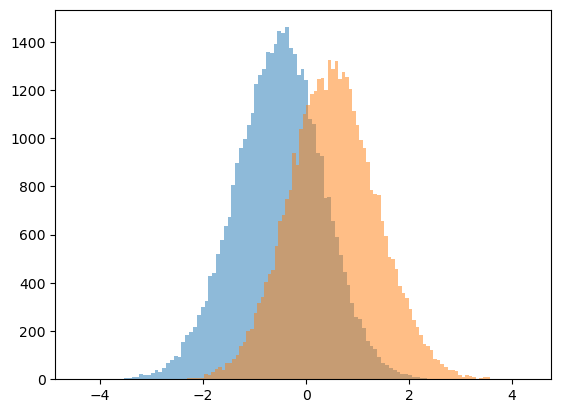

In [58]:
# Visualize synthetic data set
#================================#

x1 = df_train.loc[df_train.y==0]['x0']
x2 = df_train.loc[df_train.y==1]['x0']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, label='0')
plt.hist(x2, **kwargs, label='1')
plt.show()


#plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.xlim(50,75)
#plt.legend();

In [59]:
# Fit a logistic regression with sklearn
#==========================================#

logreg.fit(df_train[ind_var_names], df_train["y"])

print(logreg.coef_)
#print(logreg.n_features_in_)

[[ 1.71584123  0.81310739 -0.40824376]]


In [60]:
# Fit with torch implementation
#================================#

test_run = lr_train(df_train, n_epochs=1000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')
#test_run = lr_train(df_train, n_epochs=20000, learn_rate=  0.001, save_name_mod = "", loss_fun = 'mnb')

test_run['net'].linear.weight, test_run['net'].linear.bias, true_coefs

(Parameter containing:
 tensor([[ 1.7166,  0.8136, -0.4085]], requires_grad=True),
 Parameter containing:
 tensor([0.0016], requires_grad=True),
 [1.7, 0.8, -0.4])

Parameter containing:
tensor([[ 1.7166,  0.8136, -0.4085]], requires_grad=True) Parameter containing:
tensor([0.0016], requires_grad=True) [1.7, 0.8, -0.4]


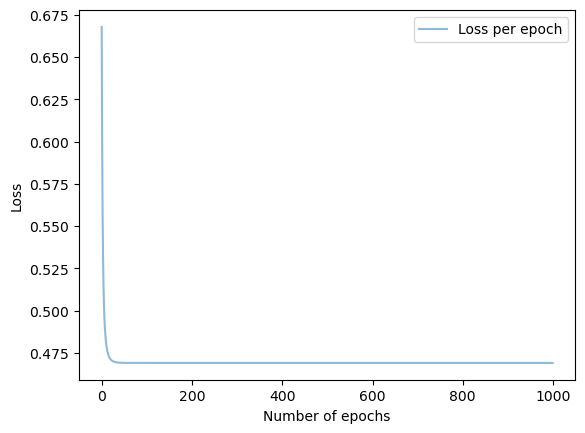

In [61]:
# Fit with torch implementation - mnb loss
#================================#

test_run_mnb = lr_train(df_train, n_epochs=500, learn_rate=  1.0, save_name_mod = "", loss_fun = 'mnb')
#test_run = reg_lr_train_legacy(df_train, n_epochs=100, learn_rate=  0.1, save_name_mod = "", loss_fun = 'mnb')

print(test_run['net'].linear.weight, test_run['net'].linear.bias, true_coefs)


# plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run['loss'] )), test_run['loss'], "-", alpha=0.5, label="Loss per epoch")
#plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [25]:
# Fit with torch minibach implementation
#=======================================

#test_run_minibatch = lr_train_minibatch(df_train, n_epochs=30, batch_size = 10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')
test_run_minibatch = lr_train_minibatch(df_train, n_epochs=60, batch_size = 10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'mnb')

test_run_minibatch['model'].linear.weight, test_run_minibatch['model'].linear.bias, true_coefs

NameError: name 'lr_train_minibatch' is not defined

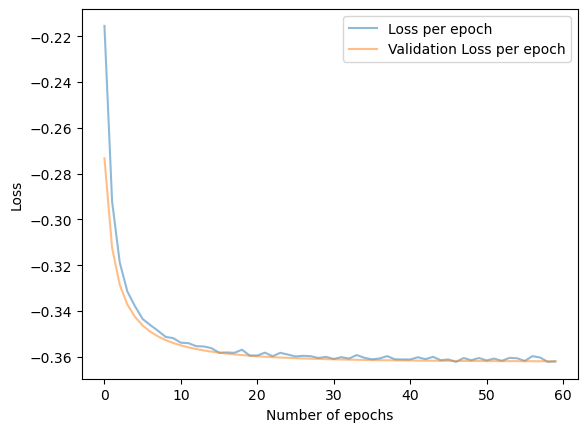

In [26]:
# Plot the loss 
#==============

# plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run_minibatch['loss_per_batch'])), test_run_minibatch['loss_per_batch'], "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [62]:
# Compare model predictions
#============================#

p1 = logreg.predict_proba(df_test[ind_var_names])

test_train_dataset_orig = SynthDataset(df_test)

test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )

p2 = torch.sigmoid(test_run['net'](test_x).detach()).numpy()

p3 = torch.sigmoid(test_run_mnb['net'](test_x).detach()).numpy()

p2

array([[0.24642365],
       [0.19658317],
       [0.57239735],
       ...,
       [0.3044898 ],
       [0.96083957],
       [0.9057409 ]], dtype=float32)

Text(0, 0.5, 'numerical optimization')

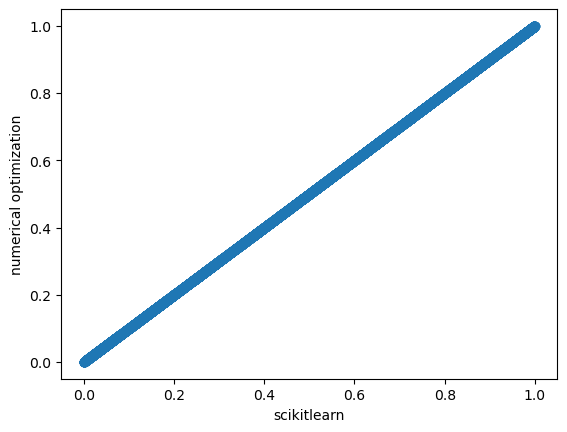

In [63]:
# Plot the comparison
#=======================#

plt.scatter(p1[:, 1], p2)
plt.xlabel("scikitlearn")
plt.ylabel("numerical optimization")

Text(0, 0.5, 'numerical optimization')

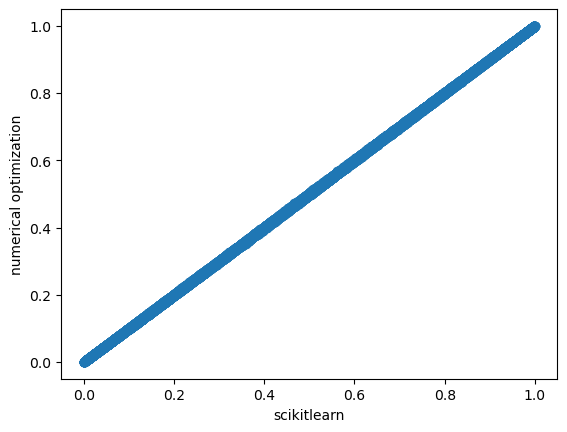

In [64]:
# Plot the comparison
#=======================#

plt.scatter(p1[:, 1], p3)
plt.xlabel("scikitlearn")
plt.ylabel("numerical optimization")

Text(0, 0.5, 'model log ods')

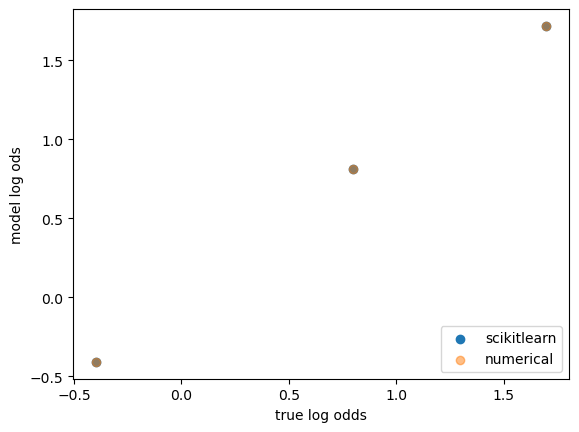

In [65]:
# Plot the comparison between the learned parameters
#====================================================#

param1 = logreg.coef_[0]
param2 = test_run['net'].linear.weight.detach().numpy()[0]

plt.scatter(true_coefs, param1, label = "scikitlearn")
plt.scatter(true_coefs, param2, label = "numerical", alpha=0.5)

plt.legend(loc='lower right')
plt.xlabel("true log odds")
plt.ylabel("model log ods")

Text(0, 0.5, 'model log ods')

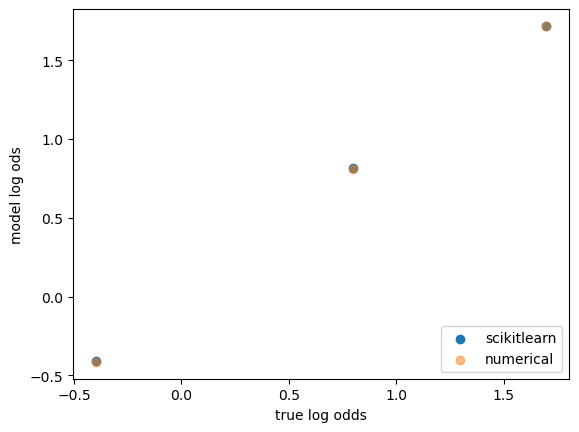

In [66]:
# Plot the comparison between the learned parameters
#====================================================#

param1 = logreg.coef_[0]
param2 = test_run_mnb['net'].linear.weight.detach().numpy()[0]

plt.scatter(true_coefs, param1, label = "scikitlearn")
plt.scatter(true_coefs, param2, label = "numerical", alpha=0.5)

plt.legend(loc='lower right')
plt.xlabel("true log odds")
plt.ylabel("model log ods")

In [67]:
# Decision curve analysis
#=========================#

#thresh = np.linspace(0.0, 1.0, num=100) 
#
#t = df_test['y']
#p = logreg.predict_proba(df_test[ind_var_names])#
#
#nb = net_benefit(t, p[:, 1] , thresholds=thresh)
#
##--------------
#
#t = df_test['y']
#test_train_dataset_orig = SynthDataset(df_test)
#test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )
#p = torch_run(test_x ).detach().numpy()
#
#nb = net_benefit(t, p, thresholds=thresh)
#
#mnb = integrate.simpson(nb[1], x=nb[0])
#
##mean_net_benefit(t, p, 100)



#t.shape
#p.shape

In [68]:
# Bootstrap distributions
# ========================= #

n_bootstraps = 300

coefs_skl = []
coefs_torch = []
coefs_torch_mnb = []

aucs_skl = []
aucs_torch = []
aucs_torch_mnb = []

mnbs_skl = []
mnbs_torch = []
mnbs_torch_mnb = []

for boot in range(n_bootstraps):
    #Make a bootstrap sample
    #-------------------------#
    df_boot = df_train.sample(frac=1, replace=True)

    #scikit learn
    #-------------
    # coefs
    logreg.fit(df_boot[ind_var_names], df_boot["y"])
    coefs_skl.append(logreg.coef_)
    #preds
    pred_skl = logreg.predict_proba(df_test[ind_var_names])
    # auc
    auc_skl = roc_auc_score(df_test['y'],pred_skl[:, 1])

    aucs_skl.append(auc_skl)
    # mnb
    mnbs_skl.append(mean_net_benefit(df_test['y'], pred_skl[:, 1], n_thresh=100)['mnb'])

    # torch
    #-------
    # coefs
    torch_run = lr_train(df_boot, n_epochs=1000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')['net']
    coefs_torch.append(torch_run.linear.weight.detach().numpy())
    #preds
    test_train_dataset_orig = SynthDataset(df_test)
    test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )
    pred_torch = torch.sigmoid(torch_run(test_x )).detach().numpy()
    #auc
    auc_torch = roc_auc_score(df_test['y'],pred_torch)
    #mnb
    mnbs_torch.append(mean_net_benefit(df_test['y'], pred_torch, n_thresh=100)['mnb'])

    aucs_torch.append(auc_torch)


    # torch -mnb
    #-------
    # coefs
    torch_run_mnb = lr_train(df_boot, n_epochs=1000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'mnb')['net']
    coefs_torch_mnb.append(torch_run_mnb.linear.weight.detach().numpy())
    #preds
    test_train_dataset_orig = SynthDataset(df_test)
    test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )
    pred_torch_mnb = torch.sigmoid(torch_run_mnb(test_x )).detach().numpy()
    #auc
    auc_torch_mnb = roc_auc_score(df_test['y'],pred_torch_mnb)
    #mnb
    mnbs_torch_mnb.append(mean_net_benefit(df_test['y'], pred_torch_mnb, n_thresh=100)['mnb'])

    aucs_torch_mnb.append(auc_torch_mnb)


coefs_skl = np.vstack(coefs_skl)
coefs_torch = np.vstack(coefs_torch)
coefs_torch_mnb = np.vstack(coefs_torch_mnb)
#rauc = roc_auc_score(y_test, y_pred_probs_positive)
#accuracy = accuracy_score(y_true, y_pred)
#precision = precision_score(y_true, y_pred)
#recall = recall_score(y_true, y_pred)
#f1 = f1_score(y_true, y_pred)

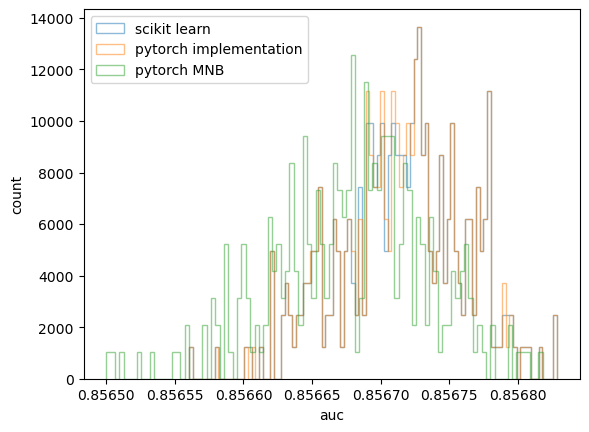

In [69]:
plt.hist(aucs_skl, **kwargs, label='scikit learn', histtype=u'step', density=True)
plt.hist(aucs_torch, **kwargs, label='pytorch implementation', histtype=u'step', density=True)
plt.hist(aucs_torch_mnb, **kwargs, label='pytorch MNB', histtype=u'step', density=True)

plt.legend(loc='upper left')
plt.xlabel("auc")
plt.ylabel("count")

plt.show()

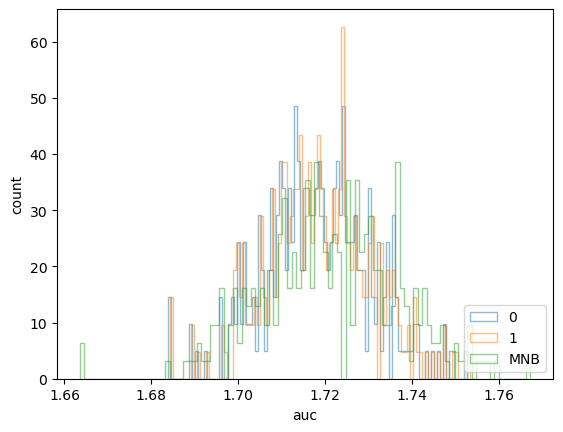

In [70]:
c = 0

plt.hist(coefs_skl[:, c], **kwargs, label='0', histtype=u'step', density=True)
plt.hist(coefs_torch[:, c], **kwargs, label='1',  histtype=u'step', density=True)
plt.hist(coefs_torch_mnb[:, c], **kwargs, label='MNB',  histtype=u'step', density=True)

plt.legend(loc='lower right')
plt.xlabel("auc")
plt.ylabel("count")

plt.show()



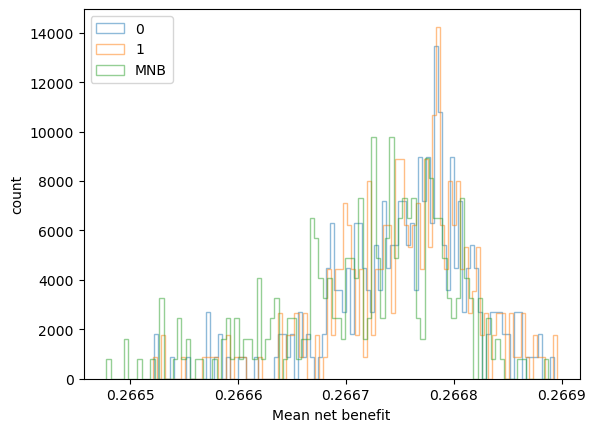

In [71]:
plt.hist(mnbs_skl, **kwargs, label='0', histtype=u'step', density=True)
plt.hist(mnbs_torch, **kwargs, label='1', histtype=u'step', density=True)
plt.hist(mnbs_torch_mnb, **kwargs, label='MNB', histtype=u'step', density=True)

plt.legend(loc='upper left')
plt.xlabel("Mean net benefit")
plt.ylabel("count")

plt.show()

## Test Torch LR with heteroskedasticity

### Agreement of LR parameters

In [17]:
# Create a dataset
#===================#
n_sample = 100000

#make_synth_data(n_features = 10, n_sample = 100000, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#make_synth_data(n_features = 3, n_sample = 100000, true_coefs = [ 3,2,1 ])

#df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
#    make_synth_data(n_features = 10, n_sample = n_sample, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])

#df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
#    make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [3, 2.5, -2.0]) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])



df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [1.7, 0.8, -0.4], true_bias=0.0, heteros=2.5) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])

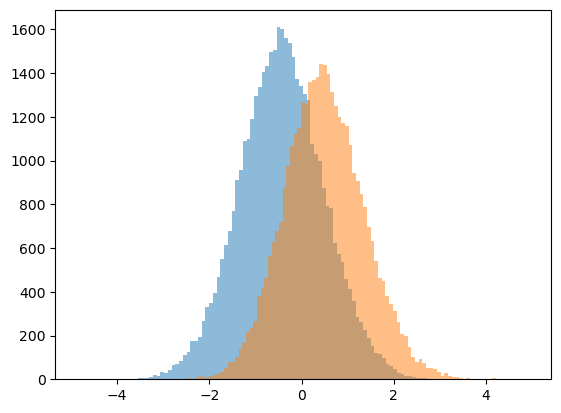

In [18]:
# Visualize synthetic data set
#================================#

x1 = df_train.loc[df_train.y==0]['x0']
x2 = df_train.loc[df_train.y==1]['x0']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, label='0')
plt.hist(x2, **kwargs, label='1')
plt.show()


#plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.xlim(50,75)
#plt.legend();

In [19]:
# Fit a logistic regression with sklearn
#==========================================#

logreg.fit(df_train[ind_var_names], df_train["y"])

print(logreg.coef_)
#print(logreg.n_features_in_)

[[ 1.29230891  0.60428642 -0.29890282]]


In [20]:
# Fit with torch implementation
#================================#

test_run = lr_train(df_train, n_epochs=1000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')
#test_run = lr_train(df_train, n_epochs=20000, learn_rate=  0.001, save_name_mod = "", loss_fun = 'mnb')

test_run['net'].linear.weight, test_run['net'].linear.bias, true_coefs

(Parameter containing:
 tensor([[ 1.2922,  0.6049, -0.2992]], requires_grad=True),
 Parameter containing:
 tensor([-0.1845], requires_grad=True),
 [1.7, 0.8, -0.4])

Parameter containing:
tensor([[ 1.2922,  0.6049, -0.2992]], requires_grad=True) Parameter containing:
tensor([-0.1845], requires_grad=True) [1.7, 0.8, -0.4]


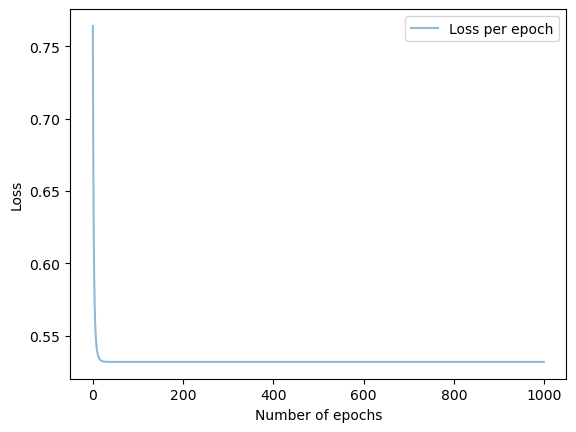

In [21]:
# Fit with torch implementation - mnb loss
#================================#

test_run_mnb = lr_train(df_train, n_epochs=500, learn_rate=  1.0, save_name_mod = "", loss_fun = 'mnb')
#test_run = reg_lr_train_legacy(df_train, n_epochs=100, learn_rate=  0.1, save_name_mod = "", loss_fun = 'mnb')

print(test_run['net'].linear.weight, test_run['net'].linear.bias, true_coefs)


# plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run['loss'] )), test_run['loss'], "-", alpha=0.5, label="Loss per epoch")
#plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [ ]:
# Fit with torch minibach implementation
#=======================================

#test_run_minibatch = lr_train_minibatch(df_train, n_epochs=30, batch_size = 10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')
test_run_minibatch = lr_train_minibatch(df_train, n_epochs=60, batch_size = 10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'mnb')

test_run_minibatch['model'].linear.weight, test_run_minibatch['model'].linear.bias, true_coefs

NameError: name 'lr_train_minibatch' is not defined

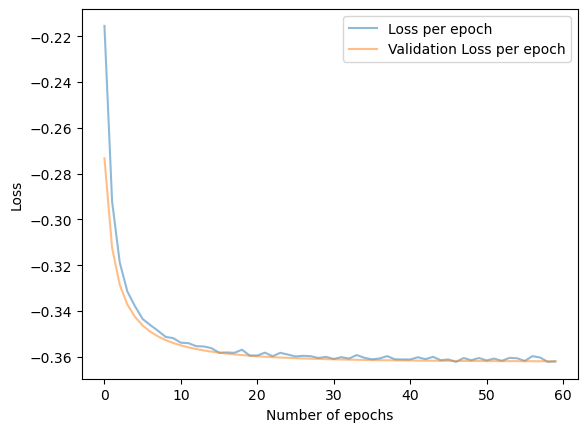

In [ ]:
# Plot the loss 
#==============

# plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run_minibatch['loss_per_batch'])), test_run_minibatch['loss_per_batch'], "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [22]:
# Compare model predictions
#============================#

p1 = logreg.predict_proba(df_test[ind_var_names])

test_train_dataset_orig = SynthDataset(df_test)

test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )

p2 = torch.sigmoid(test_run['net'](test_x).detach()).numpy()

p3 = torch.sigmoid(test_run_mnb['net'](test_x).detach()).numpy()

p2

array([[0.10393884],
       [0.48720863],
       [0.6995551 ],
       ...,
       [0.84455097],
       [0.27299076],
       [0.25532988]], dtype=float32)

Text(0, 0.5, 'numerical optimization')

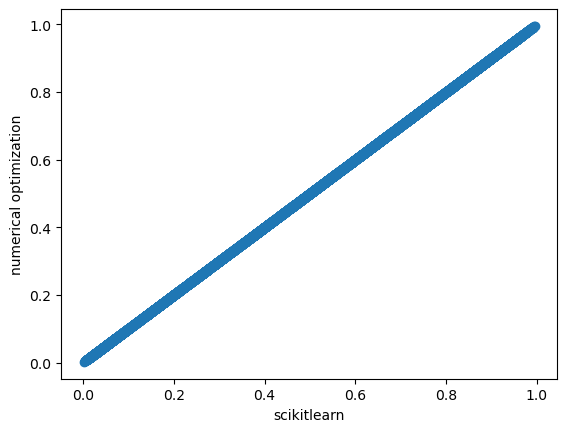

In [23]:
# Plot the comparison
#=======================#

plt.scatter(p1[:, 1], p2)
plt.xlabel("scikitlearn")
plt.ylabel("numerical optimization")

Text(0, 0.5, 'numerical optimization')

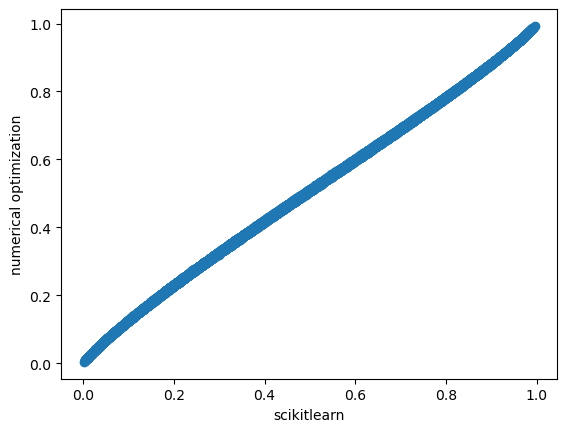

In [24]:
# Plot the comparison
#=======================#

plt.scatter(p1[:, 1], p3)
plt.xlabel("scikitlearn")
plt.ylabel("numerical optimization")

Text(0, 0.5, 'model log ods')

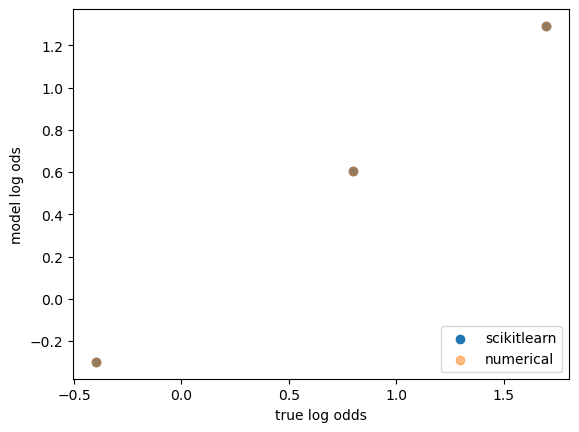

In [25]:
# Plot the comparison between the learned parameters
#====================================================#

param1 = logreg.coef_[0]
param2 = test_run['net'].linear.weight.detach().numpy()[0]

plt.scatter(true_coefs, param1, label = "scikitlearn")
plt.scatter(true_coefs, param2, label = "numerical", alpha=0.5)

plt.legend(loc='lower right')
plt.xlabel("true log odds")
plt.ylabel("model log ods")

Text(0, 0.5, 'model log ods')

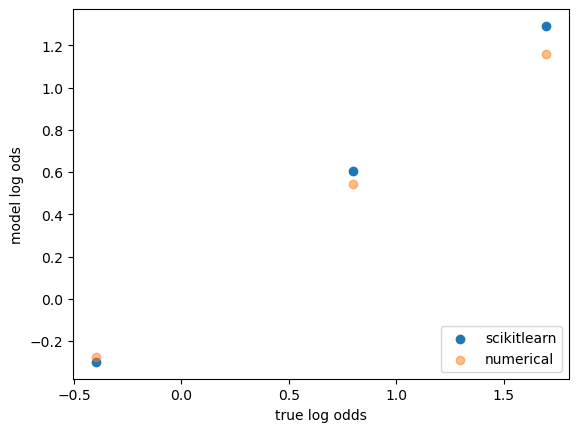

In [26]:
# Plot the comparison between the learned parameters
#====================================================#

param1 = logreg.coef_[0]
param2 = test_run_mnb['net'].linear.weight.detach().numpy()[0]

plt.scatter(true_coefs, param1, label = "scikitlearn")
plt.scatter(true_coefs, param2, label = "numerical", alpha=0.5)

plt.legend(loc='lower right')
plt.xlabel("true log odds")
plt.ylabel("model log ods")

In [ ]:
# Decision curve analysis
#=========================#

#thresh = np.linspace(0.0, 1.0, num=100) 
#
#t = df_test['y']
#p = logreg.predict_proba(df_test[ind_var_names])#
#
#nb = net_benefit(t, p[:, 1] , thresholds=thresh)
#
##--------------
#
#t = df_test['y']
#test_train_dataset_orig = SynthDataset(df_test)
#test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )
#p = torch_run(test_x ).detach().numpy()
#
#nb = net_benefit(t, p, thresholds=thresh)
#
#mnb = integrate.simpson(nb[1], x=nb[0])
#
##mean_net_benefit(t, p, 100)



#t.shape
#p.shape

{'mnb': 0.38159407909073045,
 'benefit': array([0.4987    , 0.49511786, 0.49225464, 0.48966719, 0.48697526,
        0.48440053, 0.4822629 , 0.48007989, 0.47783407, 0.4755    ,
        0.47298876, 0.47084375, 0.46838103, 0.46614709, 0.46399412,
        0.46201786, 0.45993855, 0.45748537, 0.45554444, 0.453415  ,
        0.45128924, 0.44936923, 0.44781429, 0.44585658, 0.443946  ,
        0.44216014, 0.44015342, 0.438475  , 0.43635282, 0.43446429,
        0.43273261, 0.43047794, 0.42890075, 0.427375  , 0.42600154,
        0.42443047, 0.42230714, 0.42075726, 0.41957705, 0.417715  ,
        0.41559237, 0.41371034, 0.41099211, 0.40994196, 0.4083    ,
        0.40611667, 0.40383208, 0.40165   , 0.39936471, 0.397629  ,
        0.39633776, 0.39413437, 0.39222128, 0.3905337 , 0.38864   ,
        0.3863125 , 0.3843    , 0.38296786, 0.3805561 , 0.378565  ,
        0.37660385, 0.37467368, 0.37221081, 0.3702    , 0.36797571,
        0.36500441, 0.3627    , 0.35968281, 0.35700645, 0.354055  ,
        

In [ ]:
# Bootstrap distributions
# ========================= #

n_bootstraps = 300

coefs_skl = []
coefs_torch = []
coefs_torch_mnb = []

aucs_skl = []
aucs_torch = []
aucs_torch_mnb = []

mnbs_skl = []
mnbs_torch = []
mnbs_torch_mnb = []

for boot in range(n_bootstraps):
    #Make a bootstrap sample
    #-------------------------#
    df_boot = df_train.sample(frac=1, replace=True)

    #scikit learn
    #-------------
    # coefs
    logreg.fit(df_boot[ind_var_names], df_boot["y"])
    coefs_skl.append(logreg.coef_)
    #preds
    pred_skl = logreg.predict_proba(df_test[ind_var_names])
    # auc
    auc_skl = roc_auc_score(df_test['y'],pred_skl[:, 1])

    aucs_skl.append(auc_skl)
    # mnb
    mnbs_skl.append(mean_net_benefit(df_test['y'], pred_skl[:, 1], n_thresh=100)['mnb'])

    # torch
    #-------
    # coefs
    torch_run = lr_train(df_boot, n_epochs=1000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')['net']
    coefs_torch.append(torch_run.linear.weight.detach().numpy())
    #preds
    test_train_dataset_orig = SynthDataset(df_test)
    test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )
    pred_torch = torch.sigmoid(torch_run(test_x )).detach().numpy()
    #auc
    auc_torch = roc_auc_score(df_test['y'],pred_torch)
    #mnb
    mnbs_torch.append(mean_net_benefit(df_test['y'], pred_torch, n_thresh=100)['mnb'])

    aucs_torch.append(auc_torch)


    # torch -mnb
    #-------
    # coefs
    torch_run_mnb = lr_train(df_boot, n_epochs=1000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'mnb')['net']
    coefs_torch_mnb.append(torch_run_mnb.linear.weight.detach().numpy())
    #preds
    test_train_dataset_orig = SynthDataset(df_test)
    test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )
    pred_torch_mnb = torch.sigmoid(torch_run_mnb(test_x )).detach().numpy()
    #auc
    auc_torch_mnb = roc_auc_score(df_test['y'],pred_torch_mnb)
    #mnb
    mnbs_torch_mnb.append(mean_net_benefit(df_test['y'], pred_torch_mnb, n_thresh=100)['mnb'])

    aucs_torch_mnb.append(auc_torch_mnb)


coefs_skl = np.vstack(coefs_skl)
coefs_torch = np.vstack(coefs_torch)
coefs_torch_mnb = np.vstack(coefs_torch_mnb)
#rauc = roc_auc_score(y_test, y_pred_probs_positive)
#accuracy = accuracy_score(y_true, y_pred)
#precision = precision_score(y_true, y_pred)
#recall = recall_score(y_true, y_pred)
#f1 = f1_score(y_true, y_pred)

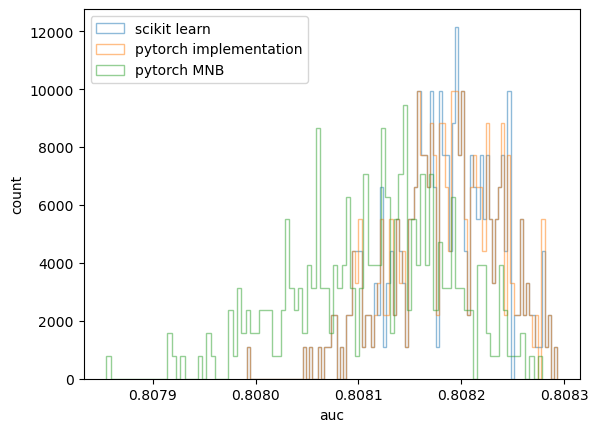

In [ ]:
plt.hist(aucs_skl, **kwargs, label='scikit learn', histtype=u'step', density=True)
plt.hist(aucs_torch, **kwargs, label='pytorch implementation', histtype=u'step', density=True)
plt.hist(aucs_torch_mnb, **kwargs, label='pytorch MNB', histtype=u'step', density=True)

plt.legend(loc='upper left')
plt.xlabel("auc")
plt.ylabel("count")

plt.show()

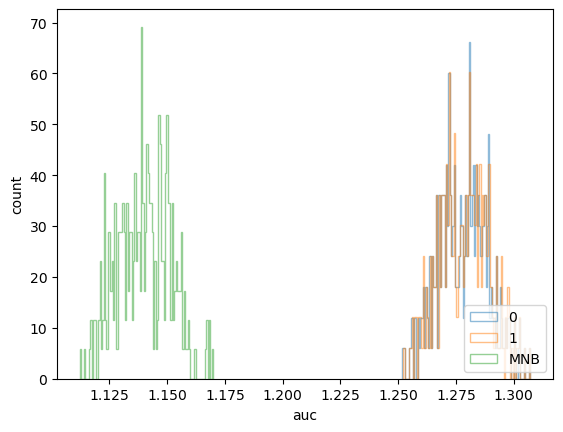

In [ ]:
c = 0

plt.hist(coefs_skl[:, c], **kwargs, label='0', histtype=u'step', density=True)
plt.hist(coefs_torch[:, c], **kwargs, label='1',  histtype=u'step', density=True)
plt.hist(coefs_torch_mnb[:, c], **kwargs, label='MNB',  histtype=u'step', density=True)

plt.legend(loc='lower right')
plt.xlabel("auc")
plt.ylabel("count")

plt.show()



In [ ]:
plt.hist(mnbs_skl, **kwargs, label='0', histtype=u'step', density=True)
plt.hist(mnbs_torch, **kwargs, label='1', histtype=u'step', density=True)
plt.hist(mnbs_torch_mnb, **kwargs, label='MNB', histtype=u'step', density=True)

plt.legend(loc='upper left')
plt.xlabel("Mean net benefit")
plt.ylabel("count")

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Create a dataset
#===================#
n_sample = 100000

#make_synth_data(n_features = 10, n_sample = 100000, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#make_synth_data(n_features = 3, n_sample = 100000, true_coefs = [ 3,2,1 ])

#df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
#    make_synth_data(n_features = 10, n_sample = n_sample, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])

#df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
#    make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [3, 2.5, -2.0]) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])



df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [1.7, 0.8, -0.4], true_bias=0.0, heteros=2.5) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])

### Test L1 regularization path

In [73]:
# Create a dataset
#===================#

#make_synth_data(n_features = 10, n_sample = 100000, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#make_synth_data(n_features = 3, n_sample = 100000, true_coefs = [ 3,2,1 ])
n_sample = 10000
df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 5, n_sample = n_sample, true_coefs = [3, 2.5, -2.0, 1.8, -1.5])# , 1.2, 0.8, 0.5, -0.2,0.1])

In [74]:
cs = l1_min_c(df_train[ind_var_names], df_train["y"], loss="log") * np.logspace(0, 5, 16)

clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(df_train[ind_var_names], df_train["y"] )
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)

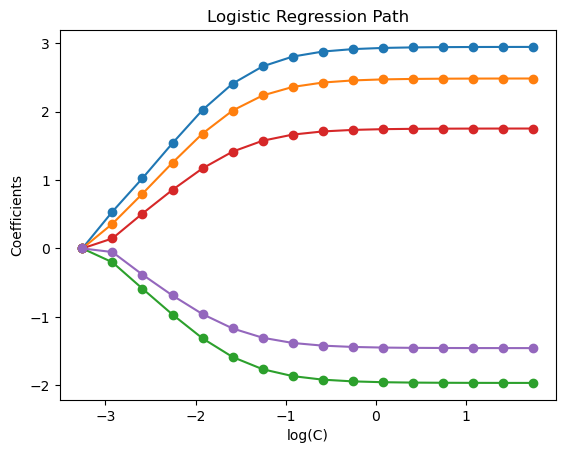

In [75]:
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

In [76]:
coefs_.shape

np.logspace(10, 0, 16)
np.logspace(0, 10, 16)


array([1.00000000e+00, 4.64158883e+00, 2.15443469e+01, 1.00000000e+02,
       4.64158883e+02, 2.15443469e+03, 1.00000000e+04, 4.64158883e+04,
       2.15443469e+05, 1.00000000e+06, 4.64158883e+06, 2.15443469e+07,
       1.00000000e+08, 4.64158883e+08, 2.15443469e+09, 1.00000000e+10])

In [81]:
cs = l1_min_c(df_train[ind_var_names], df_train["y"], loss="log") * np.logspace(5, 0, 16)

#cs = cs[0:8]
test_reg_path = {}

start_model = lr_train(df_train, n_epochs=10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')['net']

for i, inv_lambda_reg in enumerate(cs):
    print(i)
    #fm = reg_lr_train(df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])
    print("lambda")
    print(1./inv_lambda_reg)
    lda = 1./(inv_lambda_reg)
    lda = lda/n_sample
    #lda = lda/ n_features
    new_model = \
    reg_lr_train(df_train, net = start_model, n_epochs=1000, learn_rate = 1.0, loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0], lambda_reg=lda )

    test_reg_path[i] = copy.deepcopy(new_model['net'])

    start_model = copy.deepcopy(new_model['net'])


coefs_num = []

for i in test_reg_path.keys():
    coefs_num.append(test_reg_path[i].linear.weight.detach().numpy()[0])

coefs_num = np.vstack(coefs_num)


0
lambda
0.018025619895021255
1
lambda
0.03883502081116264
2
lambda
0.08366751602367907
3
lambda
0.18025619895021255
4
lambda
0.38835020811162646
5
lambda
0.8366751602367898
6
lambda
1.8025619895021254
7
lambda
3.8835020811162653
8
lambda
8.366751602367897
9
lambda
18.025619895021254
10
lambda
38.83502081116264
11
lambda
83.66751602367897
12
lambda
180.25619895021254
13
lambda
388.35020811162644
14
lambda
836.675160236789
15
lambda
1802.5619895021255


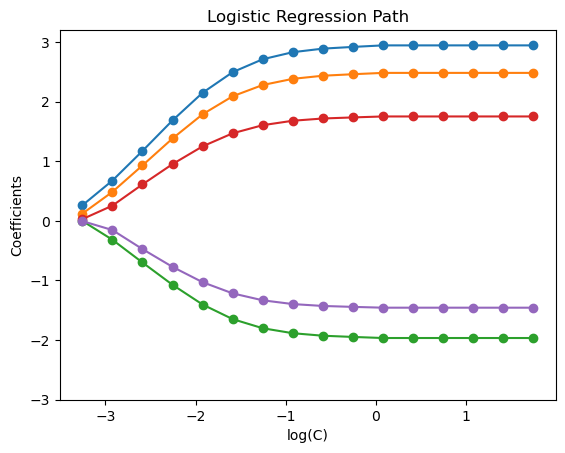

In [82]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.ylim(-3.,3.2)
plt.show()

#### Examine the efect of noisey features

In [ ]:
# Create a dataset
#===================#

#make_synth_data(n_features = 10, n_sample = 100000, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#make_synth_data(n_features = 3, n_sample = 100000, true_coefs = [ 3,2,1 ])
n_sample = 10000
df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 5, n_sample = n_sample, true_coefs = [3, 2.5, -2.0, 1.8, -1.5], noise = [10.0, 0.0, 0.0, 3.0, 10.0])

In [99]:
cs = l1_min_c(df_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(0, 10, 16)

clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(df_noisy_train[ind_var_names], df_noisy_train["y"] )
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)

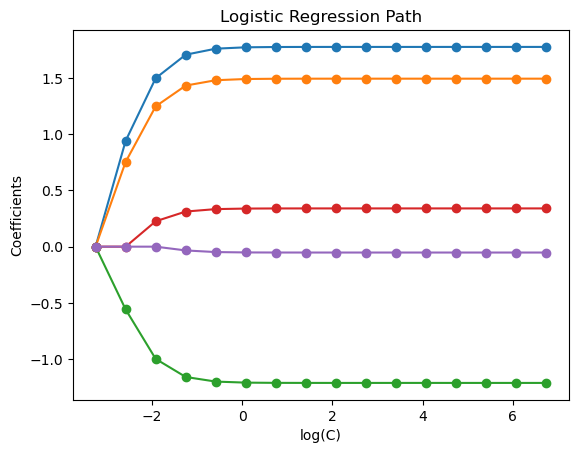

In [100]:
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

In [54]:
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(10, 0, 16)

#cs = cs[0:8]
test_reg_path = {}

start_model = lr_train(df_noisy_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'log')['net']


#history_size = 100, 
#max_iter = 20, 
#tolerance_grad=1e-07, 
#tolerance_change=1e-09,

for i, inv_lambda_reg in enumerate(cs):
    print(i)
    #fm = reg_lr_train(df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])
    print("lambda")
    print(1./inv_lambda_reg)
    lda = 1./(inv_lambda_reg)
    lda = lda/n_sample
    #lda = lda/ n_features
    new_model = \
    reg_lr_train(df_noisy_train, 
                 n_epochs=1000, 
                 learn_rate = 0.01,
                 history_size= 100,
                 max_iter= 100,
                 tolerance_grad=1e-8,
                 tolerance_change=1e-10,
                 loss_fun = 'log', 
                 regularization_type = 'L1', 
                 weights = [1.0, 1.0, 1.0], 
                 lambda_reg=lda )

    test_reg_path[i] = copy.deepcopy(new_model['net'])

    start_model = copy.deepcopy(new_model['net'])


coefs_num = []

for i in test_reg_path.keys():
    coefs_num.append(test_reg_path[i].linear.weight.detach().numpy()[0])

coefs_num = np.vstack(coefs_num)

0
lambda
1.8002222697886293e-07
1
lambda
8.355891585471941e-07
2
lambda
3.8784613078005644e-06
3
lambda
1.8002222697886294e-05
4
lambda
8.355891585471942e-05
5
lambda
0.0003878461307800557
6
lambda
0.0018002222697886291
7
lambda
0.008355891585471942
8
lambda
0.03878461307800557
9
lambda
0.18002222697886291
10
lambda
0.8355891585471942
11
lambda
3.878461307800557
12
lambda
18.002222697886292
13
lambda
83.55891585471942
14
lambda
387.8461307800549
15
lambda
1800.2222697886293


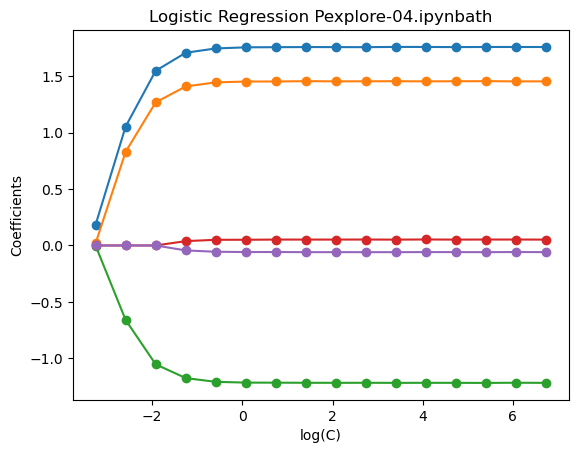

In [55]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Pexplore-04.ipynbath")
plt.axis("tight")
#plt.ylim(-3.,3.2)
plt.show()

## Weighted Lasso

In [27]:
# Create a dataset
#===================#

#make_synth_data(n_features = 10, n_sample = 100000, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#make_synth_data(n_features = 3, n_sample = 100000, true_coefs = [ 3,2,1 ])
n_sample = 10000
df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 5, n_sample = n_sample, true_coefs = [3, 2.5, -2.0, 1.8, -1.5], noise = [0.0, 0.0, 0.0, 0.0, 0.0])

In [47]:
n_sample = 1000

df_noisy_train, df_noisy_test, ind_var_names = make_class_dataset(n_sample = n_sample,
                                       n_features = 10,
                                       n_redundant = 2,
                                       random_state = 2001,
                                       n_informative = 8,
                                       n_clusters_per_class = 1,
                                       n_classes = 2)







In [29]:
df_noisy_train

,y,x0,x1,x2,x3,x4
281,0,-0.850895,-0.489947,-0.700438,0.357020,-0.459897
42,1,0.540062,0.647582,-1.066479,-0.671953,-0.696882
255,0,1.014804,-0.135872,-1.548579,0.528999,-1.331191
906,0,1.129083,0.963220,0.494918,-1.057438,0.538993
394,1,0.346342,-0.068678,-0.604576,-0.974772,0.969433
...,...,...,...,...,...,...
204,1,0.841249,1.175517,1.080256,0.511380,0.349745
53,0,1.554227,0.675740,0.528742,-0.618703,0.532519
294,1,-0.046100,1.112928,0.036328,-0.336101,-0.151528
723,0,-0.359434,-1.303079,-0.487219,1.257909,-0.099846


In [48]:
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(0, 5, 16)

clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(df_noisy_train[ind_var_names], df_noisy_train["y"] )
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)

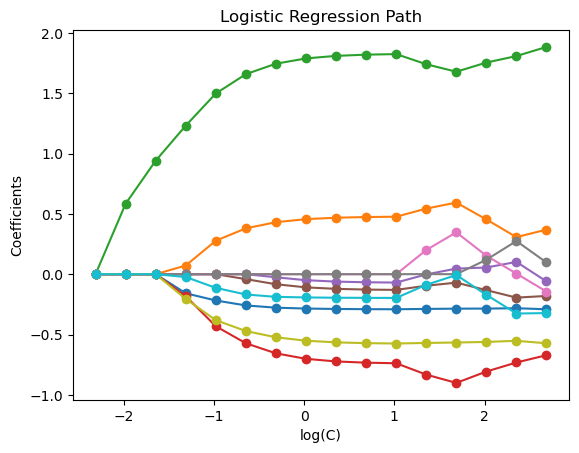

In [49]:
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

In [50]:
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(5, 0, 16)

#cs = cs[0:8]
test_reg_path = {}

start_model = lr_train(df_noisy_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'log')['net']


#history_size = 100, 
#max_iter = 20, 
#tolerance_grad=1e-07, 
#tolerance_change=1e-09,

for i, inv_lambda_reg in enumerate(cs):
    print(i)
    #fm = reg_lr_train(df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])
    print("lambda")
    print(1./inv_lambda_reg)
    lda = 1./(inv_lambda_reg)
    lda = lda/n_sample
    #lda = lda/ n_features
    new_model = \
    reg_lr_train(df_noisy_train, 
                 n_epochs=1000, 
                 learn_rate = 0.01,
                 history_size= 100,
                 max_iter= 100,
                 tolerance_grad=1e-8,
                 tolerance_change=1e-10,
                 loss_fun = 'log', 
                 regularization_type = 'L1', 
                 weights = [1.0, 1.0, 1.0], 
                 lambda_reg=lda )

    test_reg_path[i] = copy.deepcopy(new_model['net'])

    start_model = copy.deepcopy(new_model['net'])


coefs_num = []

for i in test_reg_path.keys():
    coefs_num.append(test_reg_path[i].linear.weight.detach().numpy()[0])

coefs_num = np.vstack(coefs_num)

0
lambda
0.0020548749178350596
1
lambda
0.0044270938066602655
2
lambda
0.009537884473094194
3
lambda
0.020548749178350593
4
lambda
0.044270938066602664
5
lambda
0.09537884473094184
6
lambda
0.20548749178350595
7
lambda
0.4427093806660266
8
lambda
0.9537884473094184
9
lambda
2.0548749178350594
10
lambda
4.427093806660266
11
lambda
9.537884473094184
12
lambda
20.548749178350594
13
lambda
44.27093806660266
14
lambda
95.37884473094176
15
lambda
205.48749178350596


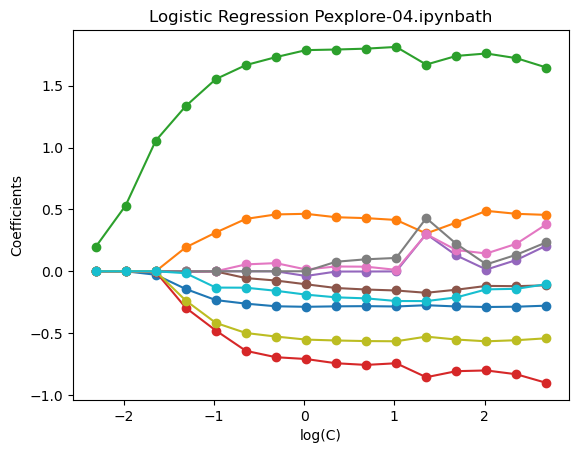

In [51]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Pexplore-04.ipynbath")
plt.axis("tight")
#plt.ylim(-3.,3.2)
plt.show()

In [52]:
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(5, 0, 16)

#cs = cs[0:8]
test_reg_path = {}

start_model = lr_train(df_noisy_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'mnb')['net']

#history_size = 100, 
#max_iter = 20, 
#tolerance_grad=1e-07, 
#tolerance_change=1e-09,

for i, inv_lambda_reg in enumerate(cs):
    print(i)
    #fm = reg_lr_train(df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])
    print("lambda")
    print(1./inv_lambda_reg)
    lda = 1./(inv_lambda_reg)
    lda = lda/n_sample
    #lda = lda/ n_features
    new_model = \
    reg_lr_train(df_noisy_train, 
                 n_epochs=1000, 
                 learn_rate = 0.01,
                 history_size= 100,
                 max_iter= 100,
                 tolerance_grad=1e-8,
                 tolerance_change=1e-10,
                 loss_fun = 'mnb', 
                 regularization_type = 'L1', 
                 weights = [1.0, 1.0, 1.0], 
                 lambda_reg=lda )

    test_reg_path[i] = copy.deepcopy(new_model['net'])

    start_model = copy.deepcopy(new_model['net'])


coefs_num = []

for i in test_reg_path.keys():
    coefs_num.append(test_reg_path[i].linear.weight.detach().numpy()[0])

coefs_num = np.vstack(coefs_num)

0
lambda
0.0020548749178350596
1
lambda
0.0044270938066602655
2
lambda
0.009537884473094194
3
lambda
0.020548749178350593
4
lambda
0.044270938066602664
5
lambda
0.09537884473094184
6
lambda
0.20548749178350595
7
lambda
0.4427093806660266
8
lambda
0.9537884473094184
9
lambda
2.0548749178350594
10
lambda
4.427093806660266
11
lambda
9.537884473094184
12
lambda
20.548749178350594
13
lambda
44.27093806660266
14
lambda
95.37884473094176
15
lambda
205.48749178350596


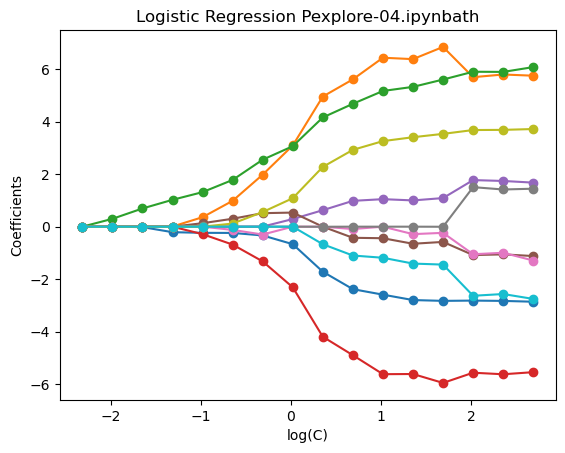

In [53]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Pexplore-04.ipynbath")
plt.axis("tight")
#plt.ylim(-3.,3.2)
plt.show()

In [54]:
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(5, 0, 16)

#cs = cs[0:8]
test_reg_path = {}

start_model = lr_train(df_noisy_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'mnb')['net']


#history_size = 100, 
#max_iter = 20, 
#tolerance_grad=1e-07, 
#tolerance_change=1e-09,

for i, inv_lambda_reg in enumerate(cs):
    print(i)
    #fm = reg_lr_train(df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])
    print("lambda")
    print(1./inv_lambda_reg)
    lda = 1./(inv_lambda_reg)
    lda = lda/n_sample
    #lda = lda/ n_features
    new_model = \
    reg_lr_train(df_noisy_train, 
                 n_epochs=1000, 
                 learn_rate = 0.01,
                 history_size= 100,
                 max_iter= 100,
                 tolerance_grad=1e-8,
                 tolerance_change=1e-10,
                 loss_fun = 'mnb', 
                 regularization_type = 'weighted_L1', 
                 weights = [1.0, 100.0, 1.0, 1.0, 10.0], 
                 lambda_reg=lda )

    test_reg_path[i] = copy.deepcopy(new_model['net'])

    start_model = copy.deepcopy(new_model['net'])


coefs_num = []

for i in test_reg_path.keys():
    coefs_num.append(test_reg_path[i].linear.weight.detach().numpy()[0])

coefs_num = np.vstack(coefs_num)

0
lambda
0.0020548749178350596


RuntimeError: The size of tensor a (5) must match the size of tensor b (10) at non-singleton dimension 1

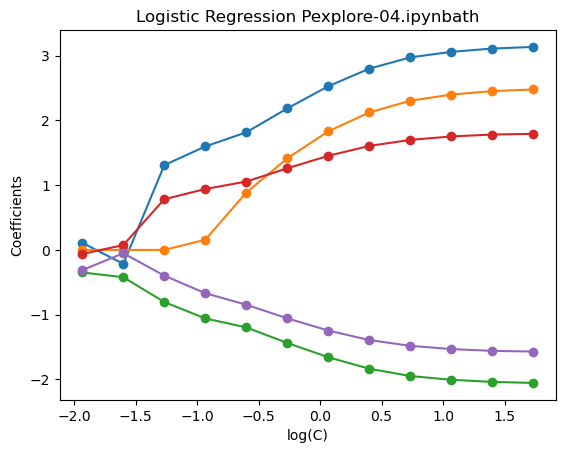

In [ ]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Pexplore-04.ipynbath")
plt.axis("tight")
#plt.ylim(-3.,3.2)
plt.show()